# Multiclass Classification

This notebook explores multiclass classification

In [1]:
import numpy as np
import plotsandgraphs as pandg
%load_ext autoreload
%autoreload 2

### Create some dummy data

In [3]:
num_classes = 3
class_labels = np.arange(num_classes)
class_probs = np.random.random(num_classes)
class_probs = class_probs / class_probs.sum() # normalize
# True labels
y_true = np.random.choice(class_labels, p=class_probs, size=1000)
# one hot encoding
y_true_one_hot = np.eye(num_classes)[y_true] 

# Predicted labels
y_pred = np.ones(y_true_one_hot.shape)

# parameters for Beta distribution for each label
a0, b0 = [0.1, 0.6, 0.3, 0.4, 2],  [0.4, 1.2, 0.8, 1, 5]
a1, b1 = [0.9, 0.8, 0.9, 1.2, 5],  [0.4, 0.1, 0.5, 0.3, 2]

# iterate through all the columns/labels and create a beta distribution for each label
for i in range(y_pred.shape[1]):
    y = y_pred[:, i]
    y_t = y_true_one_hot[:, i]
    y[y_t==0] = np.random.beta(a0[i], b0[i], size=y[y_t==0].shape)
    y[y_t==1] = np.random.beta(a1[i], b1[i], size=y[y_t==1].shape)
y_pred.shape

(1000, 3)

### Histogram of probabilities

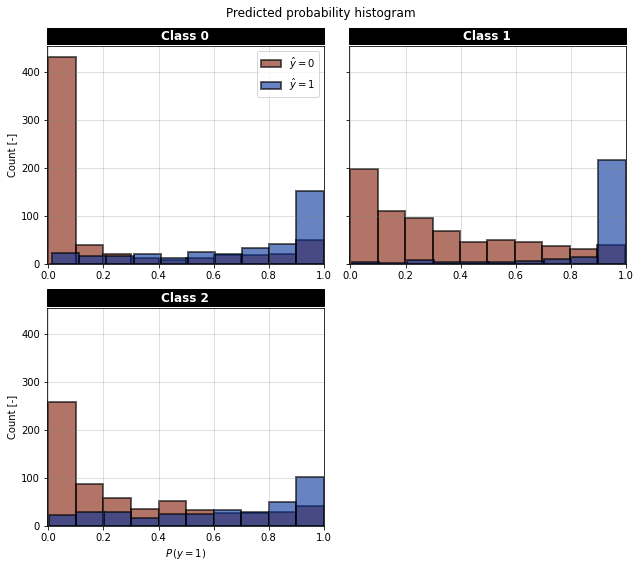

In [44]:
fig = pandg.multiclass_classifier.plot_y_prob_histogram(y_true_one_hot, y_pred)

Bootsrapping: 100%|██████████| 50/50 [00:00<00:00, 313.23it/s]


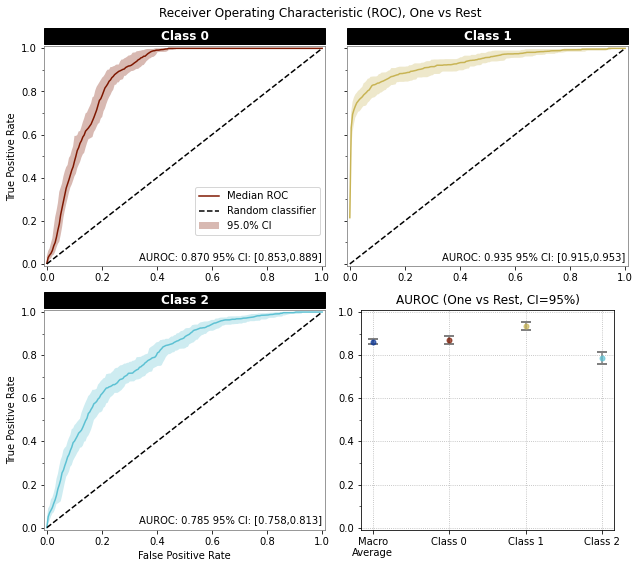

In [31]:
fig = pandg.multiclass_classifier.plot_roc_curve(y_true_one_hot, y_pred, n_bootstraps=50, highlight_roc_area=True, confidence_interval=0.95, split_plots=False)

In [22]:
for i, x in enumerate([91,2,3,4,4]):
    print(i, x)

0 91
1 2
2 3
3 4
4 4


In [ ]:
print